In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.models.cnf import CondRealNVP
from bcnf.utils import get_dir
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import load_config, load_data, sub_root_path

## Model

In [3]:
MODEL_NAME = f'trajectory_FC_large'

In [4]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = load_config(json.load(f)['config_path'])

cnf = CondRealNVP.from_config(config).to(device)

cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

cnf.eval();

In [5]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 48,415,323


In [6]:
parameter_selection = cnf.parameter_index_mapping.parameters

## Data

In [7]:
T = 2
dt = 1/15

In [8]:
data = load_data(sub_root_path(config['data']['path']).replace('/train', '/test'), verbose=True, keep_output_type='trajectories')

Loading data from directory: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it, file=fixed_data_render_2s_15FPS_5.pkl]


In [9]:
X_list = data['trajectories']

In [10]:
X = np.array(X_list)
y = cnf.parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(1000, 30, 3)
y.shape=(1000, 19)


In [11]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [12]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print(f'{X_tensor.shape=}')
print(f'{y_tensor.shape=}')

X_tensor.shape=torch.Size([1000, 30, 3])
y_tensor.shape=torch.Size([1000, 19])


## Resimulation

In [13]:
data['g_z'] = data.pop('g')
data['g_x'] = np.zeros_like(data['g_z'])
data['g_y'] = np.zeros_like(data['g_z'])

In [ ]:
# https://github.com/scipy/scipy/issues/15940
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=dt,
    y_hat=None,
    data_dict=data,
    X=X_tensor,
    m_samples=1_000,
    break_on_impact=True
)

In [24]:
X_resimulation.shape

(1000, 1000, 30, 3)

In [25]:
X.shape

(1000, 30, 3)

## Resimulation Error

In [26]:
X_error = (X_resimulation - X[:, None, :, :])

In [27]:
X_errors = np.nanmedian(X_error, axis=(1, 3))

/tmp/ipykernel_3258/3820742701.py:5: RuntimeWarning: divide by zero encountered in log10
  axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');
/tmp/ipykernel_3258/3820742701.py:5: RuntimeWarning: invalid value encountered in log10
  axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');


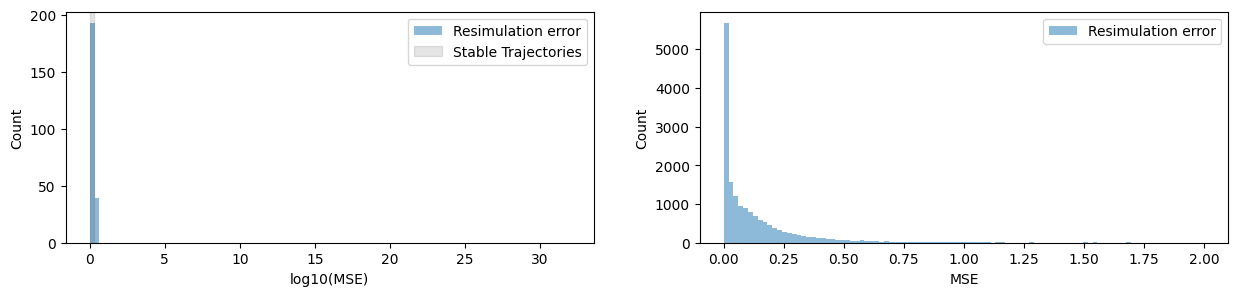

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

zoom_until = 2

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 100), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(zoom_until), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, zoom_until, 100), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

In [29]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [30]:
true_impact_indices = np.where(np.diff((X[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X[true_impact_indices[0], true_impact_indices[1]]

In [31]:
true_impact_indices[0]

array([  0,   2,   5,   6,  10,  11,  12,  16,  20,  31,  33,  34,  36,
        37,  40,  41,  43,  45,  47,  50,  54,  57,  58,  59,  60,  61,
        68,  69,  74,  80,  82,  84,  87,  88,  91,  92,  94,  98, 101,
       110, 115, 120, 123, 132, 135, 137, 139, 140, 142, 145, 146, 147,
       151, 154, 157, 158, 160, 163, 165, 166, 168, 170, 173, 174, 175,
       181, 182, 186, 187, 196, 201, 204, 209, 212, 215, 217, 221, 224,
       226, 233, 236, 238, 239, 241, 245, 248, 249, 252, 253, 254, 256,
       257, 260, 262, 268, 272, 274, 276, 277, 279, 282, 286, 292, 295,
       296, 298, 300, 302, 304, 305, 307, 309, 310, 311, 313, 315, 316,
       317, 318, 321, 322, 325, 331, 333, 336, 337, 342, 343, 344, 348,
       350, 351, 353, 355, 356, 358, 361, 362, 363, 367, 371, 375, 376,
       377, 379, 384, 387, 390, 392, 394, 399, 403, 408, 411, 415, 418,
       420, 422, 423, 424, 425, 428, 429, 431, 432, 433, 436, 437, 438,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 454, 46

In [32]:
show_index = 0
# Check if the desired validation trajectory has an impact
assert show_index in true_impact_indices[0]

X_val_impact_position = X[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :] 

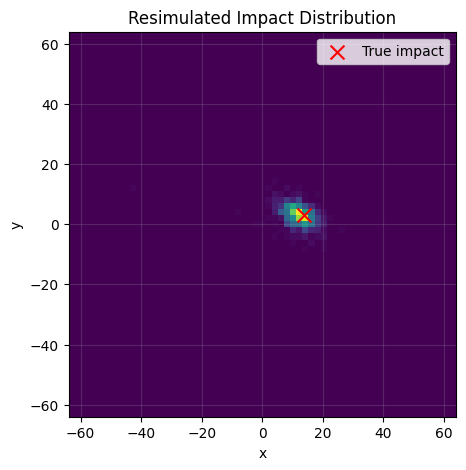

In [33]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-64, 64, 64), cmap='viridis');
ax.scatter(X_val_impact_position[0], X_val_impact_position[1], color='red', s=100, marker='x', label='True impact')
ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title('Resimulated Impact Distribution');
ax.legend();

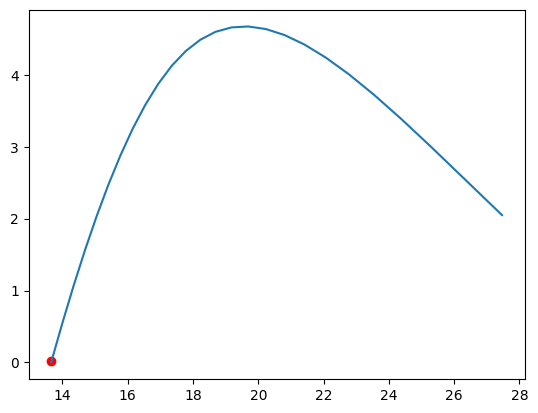

In [34]:
plt.plot(X[show_index, :, 0], X[show_index, :, -1], label='True trajectory');
plt.scatter(X_val_impact_position[0], X_val_impact_position[-1], color='red', label='Impact');

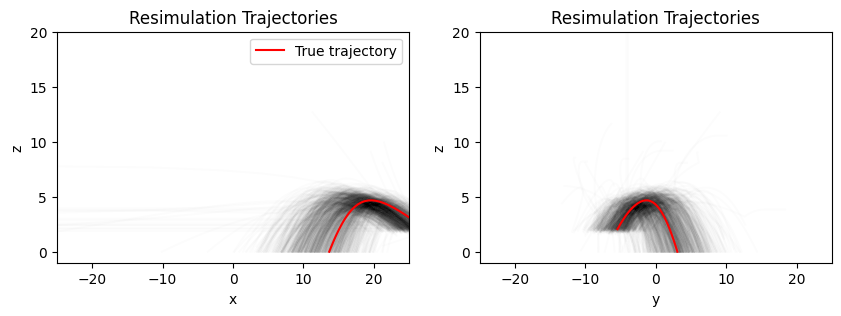

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

n_trajectories = 3000
max_time = 1000


for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
    ax.plot(X[show_index, :, i], X[show_index, :, 2], label='True trajectory', color='red');
    ax.set_xlim(-25, 25)
    ax.set_ylim(-1, 20)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.set_title('Resimulation Trajectories');

axes[0].legend();